In [1]:
import numpy as np
import copy
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import csr_matrix, csc_matrix, kron, identity
from scipy.sparse.linalg import expm

large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [2]:
# Define character sets
lowercase = 'abcdefghijklmnopqrstuvwxyz'
uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
digits = '0123456789'
special = '@#$%&'

# Combine all characters
all_chars = lowercase + uppercase + digits + special

password = ''.join(np.random.choice(list(all_chars), size=20))
print(f"Generated password: {password}")

Generated password: B8GC@fBhb##sruQ3&yRs


In [3]:
I2 = csc_matrix(np.eye(2))
sigma_x = csc_matrix(np.array([[0, 1], [1, 0]]))
sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]]))
sigma_z = csc_matrix(np.array([[1, 0], [0, -1]]))
sigma_plus = (sigma_x + 1j * sigma_y).toarray() / 2
sigma_minus = (sigma_x - 1j * sigma_y).toarray() / 2

In [24]:
def vectorize_rho(rho):
     rho = rho.toarray()
     rho_vec = rho.flatten(order="F")
     return csc_matrix(rho_vec).T

def unvectorize_rho(rho_vec):
     rho = rho_vec.toarray().reshape((2, 2), order="F")
     return csc_matrix(rho)

gamma_1 = 0.3
gamma_2 = 0.3

L = 1
J = 1
gamma_r = gamma_1
gamma_d = gamma_2
Delta = 0.5

L_1 = sigma_minus
L_2 = (I2+sigma_z)/2

def L_int(x):
     return -1j * (kron(I2, J * L * x * sigma_x) - kron(J * L * x * sigma_x, I2))

def L_f():
     return -1j * (kron(I2, - Delta * sigma_z) - kron(- Delta * sigma_z, I2))

def L_rel():
     return gamma_1 * (kron(np.conjugate(L_1), L_1)
                        - 1/2 * kron(I2, np.conjugate(L_1).T @ L_1)
                        - 1/2 * kron((np.conjugate(L_1).T @ L_1).T, I2))
def L_dep():
     return gamma_2 * (kron(np.conjugate(L_2), L_2)
                        - 1/2 * kron(I2, np.conjugate(L_2).T @ L_2)
                        - 1/2 * kron((np.conjugate(L_2).T @ L_2).T, I2))

# Cost function construction

In [25]:
# Solution for steady-state variables x, y, z
def solution_set(Delta, J, L, gamma_d, gamma_r):
    # Common term in x and y
    sqrt_term = np.sqrt(gamma_r * (gamma_r + gamma_d) / (8 * J * L * Delta))
    
    # Correction term for x and y
    correction_term = 1 - (16 * Delta**2 + (gamma_r + gamma_d)**2) / (16 * J * L * Delta)
    
    # x coordinate calculation (positive and negative solutions)
    x_pos = (4 * Delta / (gamma_r + gamma_d)) * sqrt_term * np.sqrt(correction_term)
    x_neg = -x_pos

    # y coordinate calculation (positive and negative solutions)
    y_pos = sqrt_term * np.sqrt(correction_term)
    y_neg = -y_pos

    # z coordinate calculation
    z = (-16 * Delta**2 - (gamma_r + gamma_d)**2) / (16 * J * L * Delta)

    # Returning two sets of solutions
    return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

In [26]:
def build_mean_field_hamiltonian(x_mean, J, L, Delta):
    """Hamiltonian in the mean field limit."""
    return J * L * x_mean * sigma_x - Delta * sigma_z

def jump_operators(gamma_r, gamma_d):
    """Lindblad operator acting on a single qubit."""
    L1 = np.sqrt(gamma_r) * (sigma_x - 1j * sigma_y) / 2
    L2 = np.sqrt(gamma_d) * (I2 + sigma_z) / 2
    return L1, L2

def lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """Construct the Lindblad equation."""
    H = build_mean_field_hamiltonian(x_mean, J, L, Delta)
    L1, L2 = jump_operators(gamma_r, gamma_d)

    # Commutator part: -i [H, rho]
    comm = -1j * (H @ rho - rho @ H)

    # Dissipators:
    dis1 = L1 @ rho @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    dis2 = L2 @ rho @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    return comm + dis1 + dis2

def cost_function(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """
    Cost = Tr[ (L rho)^† (L rho) ], where L is the Lindbladian superoperator.
    Here, L_rho is the matrix returned by lindbladian(rho, x_mean).
    """
    rho = csr_matrix(rho)
    L_rho = lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d)
    return np.real(L_rho.getH().dot(L_rho).diagonal().sum())

In [27]:
def variational_ansatz(number_of_layers, angles_lst, x, rho_i):
    rho = rho_i
    for i in range(number_of_layers):
        theta_int, theta_f, theta_rel, theta_dep = angles_lst[i]
        rho = expm(theta_int / 2 * L_int(x)) @ rho
        rho = expm(theta_f   / 2 * L_f())     @ rho
        rho = expm(theta_rel / 2 * L_rel())   @ rho
        rho = expm(theta_dep / 2 * L_dep())   @ rho
    return rho

# Exact variational ansatz

# def rx(theta):
#     return csc_matrix([[np.cos(theta/2), -1j*np.sin(theta/2)],
#                        [-1j*np.sin(theta/2), np.cos(theta/2)]])

# def ry(theta):
#     return csc_matrix([[np.cos(theta/2), -np.sin(theta/2)],
#                        [np.sin(theta/2), np.cos(theta/2)]])

# def rz(theta):
#     return csc_matrix([[np.exp(-1j*theta/2), 0],
#                        [0, np.exp(1j*theta/2)]])

# def cnot(control_qubit, target_qubit):
#     P0 = csc_matrix([[1, 0], [0, 0]])
#     P1 = csc_matrix([[0, 0], [0, 1]])

#     if control_qubit == 0 and target_qubit == 1:
#         cnot_matrix = kron(I2, P0) + kron(sigma_x, P1)
#     elif control_qubit == 1 and target_qubit == 0:
#         cnot_matrix = kron(P0, I2) + kron(P1, sigma_x)

#     return csc_matrix(cnot_matrix)

# def variational_ansatz(number_of_layers, angles_lst, x, rho_i):
#     P0 = csc_matrix([[1, 0], [0, 0]])
#     P1 = csc_matrix([[0, 0], [0, 1]])    
#     rho = rho_i
#     for i in range(number_of_layers):
#         theta_int, theta_f, theta_rel, theta_dep = angles_lst[i]
#         # Rx rotation on qubit one.
#         rho = kron(rx(theta_int), I2) @ rho
#         # Rz rotation on qubit one.
#         rho = kron(rz(theta_f), I2) @ rho
#         # CRy with control on qubit one and target on qubit zero.
#         rho = (kron(I2, P0) + kron(ry(theta_rel), P1)) @ rho
#         # CNOT gate with control on qubit zero and target on qubit one.
#         rho = cnot(0, 1) @ rho
#     return rho

# Quantum circuit

In [28]:
# # Variational ansatz.
# import qiskit
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import DensityMatrix, partial_trace
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.circuit.library import PauliEvolutionGate

# from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import SamplerV2 as Sampler
# #from qiskit_ibm_runtime import SamplerV2 as Sampler
# # from qiskit.primitives import StatevectorSampler
# # sampler = StatevectorSampler()
# sampler = Sampler()
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [29]:
# def ansatz_circuit(angles_lst, num_layer, num_qubit):

#      qc = QuantumCircuit(num_qubit)
#      for qubit in range(num_qubit):
#           qc.h(qubit)

#      for layer in range(num_layer):
#           for qubit in range(1,num_qubit):
#                theta_1 = angles_lst[layer][0]
#                theta_2 = angles_lst[layer][1]               
#                theta_r = angles_lst[layer][2]
#                theta_d = angles_lst[layer][3]
#                qc.rx(theta_1,qubit)
#                qc.rz(theta_2,qubit)

#                qc.cry(theta_r, qubit, 0)
#                qc.cx(0, qubit)

#                qc.reset(0)

#                qc.cry(theta_d, qubit, 0)

#                qc.reset(0)  

#      return qc

# number_of_layers = 1
# initial_thetas = [[0.1, 0.1, 0.1, 0.2] for _ in range(number_of_layers)]

# x = 1.5
# dt = 0.2
# ansatz_circuit(initial_thetas, num_layer=number_of_layers, num_qubit=2).draw('mpl', scale = 2)#.savefig('variational_circuit.pdf', dpi=600, bbox_inches='tight')

In [30]:
# # [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# # https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

# from qiskit_aer import AerSimulator
# from qiskit import transpile

# from qiskit_aer.primitives import SamplerV2 as Sampler
# #from qiskit_ibm_runtime import SamplerV2 as Sampler
# # from qiskit.primitives import StatevectorSampler
# # sampler = StatevectorSampler()
# sampler = Sampler()


# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# # YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# # QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# # service = QiskitRuntimeService()
# # backend = service.backend("ibm_brisbane")
# # noise_model = NoiseModel.from_backend(backend)

# def return_density_matrix(quantum_circuit):

#      quantum_circuit.save_density_matrix()  # Save the density matrix

#      # Step 2: Simulate the circuit
#      simulator = AerSimulator()  # Aer simulator supports reset gates
#      quantum_circuit = transpile(quantum_circuit, simulator)
#      result = simulator.run(quantum_circuit).result()
#      # Step 3: Extract the density matrix
#      rho_full = DensityMatrix(result.data()["density_matrix"])

#      # Step 4: Compute the reduced density matrix for the second qubit
#      rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
#      rho_1_matrix = rho_1.data

#      return rho_1_matrix

# def update_angles(x, current_angles_lst, number_of_layers, learning_rate):
#     """
#     Perform parameter-shift updates on angles for a VQA circuit.
    
#     Parameters:
#         current_angles_lst (list of lists): Current angles for each layer (shape: [number_of_layers, 8]).
#         number_of_layers (int): Number of layers in the VQA circuit.
#         learning_rate (float): Learning rate for gradient descent.

#     Returns:
#         updated_angles (list of lists): Updated angles after applying parameter-shift rule.
#     """
#     # Initialize the updated angles as a copy of the current angles
#     updated_angles = np.array(current_angles_lst, copy=True)
    
#     # Iterate over each layer and each parameter
#     for i in range(number_of_layers):
#         for j in range(4):
#             # Create shifted angle sets for parameter (i, j)
#             angles_plus = np.array(current_angles_lst, copy=True)
#             angles_minus = np.array(current_angles_lst, copy=True)
            
#             # Shift the specific parameter
#             angles_plus[i][j] += np.pi / 2
#             angles_minus[i][j] -= np.pi / 2
            
#             # Compute the cost for shifted parameters
#             # ansatz_circuit(angles_lst, x, dt, number_of_layers, num_qubit=2)
#             cost_plus = cost_function(return_density_matrix(ansatz_circuit(angles_plus, number_of_layers, num_qubit=2)), x, J, L, Delta, gamma_r, gamma_d)
#             cost_minus = cost_function(return_density_matrix(ansatz_circuit(angles_minus, number_of_layers, num_qubit=2)), x, J, L, Delta, gamma_r, gamma_d)
            
#             # Compute the gradient for this parameter
#             gradient = (cost_plus - cost_minus) / 2
            
#             # Update the parameter using gradient descent
#             updated_angles[i][j] -= learning_rate * gradient
    
#     return updated_angles

# Optimization

In [31]:
# # Parameters
# initial_learning_rate = 0.1
# number_of_layers = 1
# max_iterations = 20
# tolerance_for_convergence = 1e-2

# initial_angles_lst = [[1.5, -0.5, 2.5, 1.5] for _ in range(number_of_layers)]
# angles_lst = initial_angles_lst.copy()
# best_angles_lst = initial_angles_lst.copy()

# # Initialize optimization variables
# number_of_iteration = 0
# best_cost = float("inf")
# best_iteration = 0
# cost_function_values_lst = []

# # Initial value of x from the density matrix
# rho_i = np.array([[1, 1], [1, 1]]) / 2
# x = np.real(np.trace(rho_i @ sigma_x))
# rho_lst = [rho_i]

# x_values_lst = [x**2]

# # Print initial state
# print("Initial angles: ", initial_angles_lst)

# # Optimization loop
# while number_of_iteration < max_iterations:
    
#     # Generate variational circuit and compute cost
#     vqa_circuit = ansatz_circuit(angles_lst, number_of_layers, num_qubit=2)
#     rho = return_density_matrix(vqa_circuit)
#     rho_lst.append(rho)
#     cost_value =  cost_function(rho, x, J, L, Delta, gamma_r, gamma_d)

#     # Value of x from the density matrix
#     x = np.real(np.trace(rho @ sigma_x))
#     x_values_lst.append(x**2)

#     # Record and display the cost
#     cost_function_values_lst.append(cost_value)
#     print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.10f}")

#     # Update best solution
#     if cost_value < best_cost:
#         best_cost = cost_value
#         best_angles_lst = angles_lst.copy()
#         best_iteration = number_of_iteration

#     # Check for convergence
#     if cost_value < tolerance_for_convergence:
#         print("Optimization has converged.")
#         print(f"Best cost value: {best_cost:.10f}")
#         print("Best angles:", best_angles_lst)
#         break

#     # Adjust learning rate
#     learning_rate = initial_learning_rate / (0.1*number_of_iteration + 1)

#     # Update angles using the parameter-shift rule
#     angles_lst = update_angles(x, angles_lst, number_of_layers, learning_rate)

#     # Increment iteration counter
#     number_of_iteration += 1

# # Post-optimization summary
# if number_of_iteration == max_iterations:
#     print("The optimization did not converge within the maximum iterations.")
# print(f"Best cost value: {best_cost:.10f}")
# print("Best angles:", best_angles_lst)
# print('Variational solution: x = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_x)), 
#     'y = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_y)), 
#     'z = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_z)))
# print('Exact solution:', solution_set(Delta, J, L, gamma_d, gamma_r)[0])

In [32]:
# x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]
# # Plotting the cost function vs iterations with publication-quality settings.
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(cost_function_values_lst, marker='o', linestyle='-', color='blue', markersize=10, linewidth=2, label='Cost Function')
# print('Best cost: ', cost_function_values_lst[-1])
# ax.plot(np.array(x_values_lst)**2, marker='h', linestyle='-', color='red', markersize=10, linewidth=2, label=r'$x(t)^{2}$')
# plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
# plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
# ax.set_xlabel('Iteration', labelpad=20)
# ax.set_ylabel('Cost', labelpad=20)
# ax.legend()
# plt.tight_layout()
# for spine in ax.spines.values():
#      spine.set_linewidth(2)
# ax.tick_params(axis='both', which='major', length=10)
# plt.show()

# General gradient descent algorithm for optimization

In [33]:
# Updated gradient descent function using general finite difference gradient estimation
def gradient_descent_optimizer(rho_initial, number_of_layers, angles_lst, learning_rate=0.01, max_iterations=100, tolerance=1e-6, delta=np.pi/10):
    rho_vec = rho_initial
    rho_vec_lst = [rho_initial]
    x_val = np.real((sigma_x @ unvectorize_rho(rho_initial)).diagonal().sum())
    cost_function_value = cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2)
    cost_function_lst = [cost_function_value]
    x_values_lst = [x_val]
    best_angles_lst = copy.deepcopy(angles_lst)
    best_cost = float('inf')

    for iteration in range(max_iterations):
        current_learning_rate = learning_rate
        rho = rho_vec_lst[-1]
        x_val = np.real((sigma_x @ unvectorize_rho(rho)).diagonal().sum())
        x_values_lst.append(x_val)
        rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho))
        rho_vec_lst.append(rho_vec)
        cost_function_value = np.real(cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2))
        cost_function_lst.append(cost_function_value)

        if cost_function_value < best_cost:
            best_cost = cost_function_value
            best_angles_lst = copy.deepcopy(angles_lst)

        if iteration > 0 and abs(cost_function_lst[-1] - cost_function_lst[-2]) < tolerance:
            break

        gradients = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]

        for layer in range(number_of_layers):
            for p in range(4):
                angles_plus = copy.deepcopy(angles_lst)
                angles_minus = copy.deepcopy(angles_lst)
                angles_plus[layer][p] += delta
                angles_minus[layer][p] -= delta

                rho_plus_vec = variational_ansatz(number_of_layers, angles_plus, x_val, vectorize_rho(rho))
                rho_minus_vec = variational_ansatz(number_of_layers, angles_minus, x_val, vectorize_rho(rho))
                cost_plus = cost_function(unvectorize_rho(rho_plus_vec), x_val, J, L, Delta, gamma_1, gamma_2)
                cost_minus = cost_function(unvectorize_rho(rho_minus_vec), x_val, J, L, Delta, gamma_1, gamma_2)
                gradients[layer][p] = (cost_plus - cost_minus) / (2 * delta)

        for layer in range(number_of_layers):
            for p in range(4):
                angles_lst[layer][p] -= current_learning_rate * gradients[layer][p]

    return best_angles_lst, best_cost, x_values_lst, rho_vec_lst, cost_function_lst

In [34]:
x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]

number_of_layers = 2
initial_thetas = [[0.1, 0.1, 0.1, 0.2] for _ in range(number_of_layers)]

rho_i = vectorize_rho( csr_matrix( I2 + sigma_x) / 2)

best_angles, best_cost, x_values, rho_values, cost_values = gradient_descent_optimizer(
    rho_i, number_of_layers, initial_thetas, learning_rate=0.1, max_iterations=100
)

/Users/sasankadowarah/Ultimate_QM_MM/OPESH/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/sasankadowarah/Ultimate_QM_MM/OPESH/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/sasankadowarah/Ultimate_QM_MM/OPESH/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Best cost:  1.3768977869531152e-05


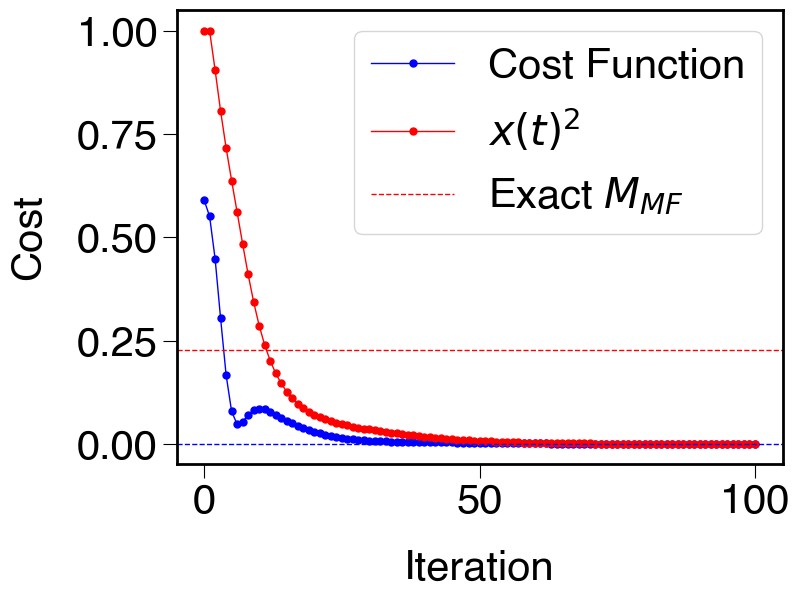

In [35]:
# Plotting the cost function vs iterations with publication-quality settings.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(cost_values, marker='o', linestyle='-', color='blue', markersize=5, linewidth=1, label='Cost Function')
print('Best cost: ', cost_values[-1])
ax.plot(np.array(x_values)**2, marker='o', linestyle='-', color='red', markersize=5, linewidth=1, label=r'$x(t)^{2}$')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
ax.set_xlabel('Iteration', labelpad=20)
ax.set_ylabel('Cost', labelpad=20)
ax.legend()
plt.tight_layout()
for spine in ax.spines.values():
     spine.set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
plt.show()

# Adam optimizer

In [36]:
# # Adam optimizer version of the gradient descent function

# def adam_optimizer(
#     rho_initial, number_of_layers, angles_lst,
#     learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8,
#     max_iterations=100, tolerance=1e-6, delta=np.pi / 2
# ):
#     rho_vec = rho_initial
#     rho_vec_lst = [rho_initial]
#     x_val = np.real((sigma_x @ unvectorize_rho(rho_initial)).diagonal().sum())
#     cost_function_value = cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2)
#     cost_function_lst = [cost_function_value]
#     x_values_lst = [x_val]
#     best_angles_lst = copy.deepcopy(angles_lst)
#     best_cost = float('inf')

#     m = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]
#     v = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]

#     for iteration in range(1, max_iterations + 1):
#         rho = rho_vec_lst[-1]
#         x_val = np.real((sigma_x @ unvectorize_rho(rho)).diagonal().sum())
#         x_values_lst.append(x_val)
#         rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho))
#         rho_vec_lst.append(rho_vec)
#         cost_function_value = np.real(cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2))
#         cost_function_lst.append(cost_function_value)

#         if cost_function_value < best_cost:
#             best_cost = cost_function_value
#             best_angles_lst = copy.deepcopy(angles_lst)

#         if iteration > 1 and abs(cost_function_lst[-1] - cost_function_lst[-2]) < tolerance:
#             break

#         gradients = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]

#         for layer in range(number_of_layers):
#             for p in range(4):
#                 angles_plus = copy.deepcopy(angles_lst)
#                 angles_minus = copy.deepcopy(angles_lst)
#                 angles_plus[layer][p] += delta
#                 angles_minus[layer][p] -= delta

#                 rho_plus_vec = variational_ansatz(number_of_layers, angles_plus, x_val, vectorize_rho(rho))
#                 rho_minus_vec = variational_ansatz(number_of_layers, angles_minus, x_val, vectorize_rho(rho))
#                 cost_plus = cost_function(unvectorize_rho(rho_plus_vec), x_val, J, L, Delta, gamma_1, gamma_2)
#                 cost_minus = cost_function(unvectorize_rho(rho_minus_vec), x_val, J, L, Delta, gamma_1, gamma_2)
#                 gradients[layer][p] = (cost_plus - cost_minus) / (2 * delta)

#         for layer in range(number_of_layers):
#             for p in range(4):
#                 g = gradients[layer][p]
#                 m[layer][p] = beta1 * m[layer][p] + (1 - beta1) * g
#                 v[layer][p] = beta2 * v[layer][p] + (1 - beta2) * (g ** 2)

#                 m_hat = m[layer][p] / (1 - beta1 ** iteration)
#                 v_hat = v[layer][p] / (1 - beta2 ** iteration)

#                 angles_lst[layer][p] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

#     return best_angles_lst, best_cost, x_values_lst, rho_vec_lst, cost_function_lst

In [37]:
# x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]

# number_of_layers = 2
# initial_thetas = [[0.1, 0.1, 0.1, 0.2] for _ in range(number_of_layers)]

# rho_i = vectorize_rho( csr_matrix( I2 + sigma_x) / 2)

# best_angles, best_cost, x_values, rho_values, cost_values = adam_optimizer(
#     rho_i, number_of_layers, initial_thetas,
#     learning_rate=0.05, max_iterations=100)

In [38]:
# # Plotting the cost function vs iterations with publication-quality settings.
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(cost_values, marker='o', linestyle='-', color='blue', markersize=5, linewidth=1, label='Cost Function')
# print('Best cost: ', cost_values[-1])
# ax.plot(np.array(x_values)**2, marker='o', linestyle='-', color='red', markersize=5, linewidth=1, label=r'$x(t)^{2}$')
# plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
# plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
# ax.set_xlabel('Iteration', labelpad=20)
# ax.set_ylabel('Cost', labelpad=20)
# ax.legend()
# plt.tight_layout()
# for spine in ax.spines.values():
#      spine.set_linewidth(2)
# ax.tick_params(axis='both', which='major', length=10)
# plt.show()

# Gradient descent

In [39]:
# def compute_gradients(rho, number_of_layers, angles_lst):
#     x = (sigma_x @ unvectorize_rho(rho)).diagonal().sum()
#     gradients = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]
#     for layer in range(number_of_layers):
#         for p in range(4):
#             angles_plus = copy.deepcopy(angles_lst)
#             angles_minus = copy.deepcopy(angles_lst)
#             angles_plus[layer][p] += np.pi / 2
#             angles_minus[layer][p] -= np.pi / 2
#             rho_plus_vec = variational_ansatz(number_of_layers, angles_plus, x, vectorize_rho(rho))
#             rho_minus_vec = variational_ansatz(number_of_layers, angles_minus, x, vectorize_rho(rho))
#             cost_plus = cost_function(unvectorize_rho(rho_plus_vec), x, J, L, Delta, gamma_r, gamma_d)
#             cost_minus = cost_function(unvectorize_rho(rho_minus_vec), x, J, L, Delta, gamma_r, gamma_d)
#             gradients[layer][p] = (cost_plus - cost_minus) / 2
#     return gradients
    
# def gradient_descent_optimizer(rho_initial, number_of_layers, angles_lst, learning_rate=0.1, max_iterations=50, tolerance=1e-6):
#     x_val = np.real((sigma_x @ unvectorize_rho(rho_initial)).diagonal().sum())
#     rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho_initial))
#     rho_vec_lst = [rho_initial]
#     cost_function_value = cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_r, gamma_d)
#     cost_function_lst = [cost_function_value]
#     x_values_lst = [x_val]
#     best_angles_lst = copy.deepcopy(angles_lst)
#     best_cost = float('inf')
    
#     for iteration in range(max_iterations):
#         print('Iteration number:', iteration)
#         current_learning_rate = learning_rate / (iteration + 1)
#         print('Current learning rate:', current_learning_rate)
#         rho = rho_vec_lst[-1]
#         x_val = np.real((sigma_x @ unvectorize_rho(rho)).diagonal().sum())
#         x_values_lst.append(x_val)
#         rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho))
#         rho_vec_lst.append(rho_vec)
#         cost_function_value = np.real(cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_r, gamma_d))
#         cost_function_lst.append(cost_function_value)
#         print('Cost function value:', cost_function_value)
#         if cost_function_value < best_cost:
#             best_cost = cost_function_value
#             best_angles_lst = copy.deepcopy(angles_lst)
#         if iteration > 0 and abs(cost_function_lst[-1] - cost_function_lst[-2]) < tolerance:
#             break
#         gradients = compute_gradients(rho, number_of_layers, angles_lst)
#         for layer in range(number_of_layers):
#             for p in range(4):
#                 angles_lst[layer][p] -= current_learning_rate * gradients[layer][p]
#     return best_angles_lst, best_cost, x_values_lst, rho_vec_lst, cost_function_lst

# Optimization

In [40]:
# x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]

# number_of_layers = 1
# initial_thetas = [[0.1, 0.1, 0.1, 0.2] for _ in range(number_of_layers)]

# rho_i = vectorize_rho( csr_matrix( I2 + sigma_x) / 2)

# best_angles, best_cost, x_values, rho_values, cost_values = gradient_descent_optimizer(rho_i, number_of_layers, initial_thetas)
# print('Best angles: ', best_angles)

In [41]:
# # Plotting the cost function vs iterations with publication-quality settings.
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(cost_values, marker='o', linestyle='-', color='blue', markersize=5, linewidth=1, label='Cost Function')
# print('Best cost: ', cost_values[-1])
# ax.plot(np.array(x_values)**2, marker='o', linestyle='-', color='red', markersize=5, linewidth=1, label=r'$x(t)^{2}$')
# plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
# plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
# ax.set_xlabel('Iteration', labelpad=20)
# ax.set_ylabel('Cost', labelpad=20)
# ax.legend()
# plt.tight_layout()
# for spine in ax.spines.values():
#      spine.set_linewidth(2)
# ax.tick_params(axis='both', which='major', length=10)
# plt.show()

In [42]:
# # Define ranges for all four angles
# theta1_range = np.linspace(-1.5, 1.5, 10)
# theta2_range = np.linspace(-1.5, 1.5, 10)
# theta3_range = np.linspace(-1.5, 1.5, 10)
# theta4_range = np.linspace(-1.5, 1.5, 10)

# # Use the initial rho_i to compute the initial x value
# x_initial = np.real((sigma_x @ unvectorize_rho(rho_i)).diagonal().sum())

# # Prepare an array to store cost values for each (theta1, theta2) pair,
# # where the cost is minimized over theta3 and theta4
# cost_landscape = np.zeros((len(theta1_range), len(theta2_range)))

# for i, t1 in enumerate(theta1_range):
#      for j, t2 in enumerate(theta2_range):
#           cost_vals = []
#           for t3 in theta3_range:
#                for t4 in theta4_range:
#                     rho_out = variational_ansatz(t1, t2, t3, t4, x_initial, rho_i)
#                     cost = cost_function(unvectorize_rho(rho_out), x_initial, J, L, Delta, gamma_r, gamma_d)
#                     cost_vals.append(cost)
#           cost_landscape[i, j] = np.min(cost_vals)  # you could also use np.mean(cost_vals)

In [43]:
# from mpl_toolkits.mplot3d import Axes3D

# T1, T2 = np.meshgrid(theta1_range, theta2_range)

# fig = plt.figure(figsize=(12, 8))
# ax_3d = fig.add_subplot(111, projection='3d')

# # Create a 3D surface plot
# surf = ax_3d.plot_surface(T1, T2, cost_landscape, cmap='viridis', edgecolor='none')

# # Add a color bar
# cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)
# cbar.set_label('Cost Function', labelpad=20)

# # Set axis labels and title
# ax_3d.set_xlabel(r'$\theta_1$', fontsize=med, labelpad=20)
# ax_3d.set_ylabel(r'$\theta_2$', fontsize=med, labelpad=20)
# ax_3d.set_zlabel('Cost', fontsize=med, labelpad=20)
# plt.tight_layout()
# plt.show()